In [47]:
import pandas as pd

In [48]:
ux = pd.read_csv('Datos/Datos UX/page_views.csv')

In [49]:
ux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       794 non-null    int64 
 1   event_name       794 non-null    object
 2   section          794 non-null    object
 3   user_id          794 non-null    object
 4   event_date       794 non-null    object
 5   event_timestamp  794 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.3+ KB


In [50]:
# cambio tipo datos fecha
ux['event_date'] = pd.to_datetime(ux['event_date'])
ux['event_timestamp'] = pd.to_datetime(ux['event_timestamp'])  

In [51]:
ux.dtypes

Unnamed: 0                  int64
event_name                 object
section                    object
user_id                    object
event_date         datetime64[ns]
event_timestamp    datetime64[ns]
dtype: object

In [52]:
columns = ['section']

for column in columns:
    print(f"Valores únicos de la columna '{column}':")
    print(ux[column].unique())
    print("\n")

Valores únicos de la columna 'section':
['quiz_work' 'quiz_fit' 'quiz_highlight' 'quiz_bodyShape' 'quiz_eyes'
 'quiz_hair' 'quiz_sizes' 'quiz_measurements' 'quiz_focus'
 'quiz_adventurous' 'quiz_styles' 'quiz_prices' 'quiz_avoid'
 'quiz_footwear' 'quiz_you' 'quiz_photos' 'quiz_social' 'quiz_signUp'
 'quiz_leisure']




In [53]:
# Comprobacion de que estan ordenado el df por id y dentro de eso por el timestamp, para asegurar que esta en orden
ux.sort_values(by=['user_id', 'event_timestamp']).equals(ux)

True

### Se cambia el formato de la tabla para tener los recorridos de cada user y ver si avanza, retrocede o recarga

In [54]:
import pandas as pd

# Orden de las secciones del test
section_order = [
    'quiz_leisure', 'quiz_work', 'quiz_fit', 'quiz_highlight', 'quiz_bodyShape',
    'quiz_eyes', 'quiz_hair', 'quiz_sizes', 'quiz_measurements', 'quiz_focus',
    'quiz_adventurous', 'quiz_styles', 'quiz_prices', 'quiz_avoid',
    'quiz_footwear', 'quiz_you', 'quiz_photos', 'quiz_social', 'quiz_signUp'
]

# Crear un diccionario para asignar un índice a cada sección
section_indices = {section: idx for idx, section in enumerate(section_order)}

# Función para categorizar los movimientos
def categorize_movement(sections):
    movements = []
    for i in range(1, len(sections)):
        prev_idx = section_indices[sections[i - 1]]
        curr_idx = section_indices[sections[i]]
        if curr_idx > prev_idx:
            movements.append("Avanza")
        elif curr_idx == prev_idx:
            movements.append("Recarga")
        else:
            movements.append("Retrocede")
    return movements

# Función para calcular el tiempo pasado en cada página en formato HH:MM:SS
def calculate_time_spent(timestamps):
    time_spent = []
    for i in range(1, len(timestamps)):
        delta = (timestamps[i] - timestamps[i - 1]).total_seconds()
        hours, remainder = divmod(delta, 3600)
        minutes, seconds = divmod(remainder, 60)
        time_spent.append(f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}")
        
    time_spent.append("00:00:15")
    return time_spent

# Leer el archivo CSV y convertir la columna 'event_timestamp' a datetime
ux = pd.read_csv('Datos/Datos UX/page_views.csv')
ux['event_timestamp'] = pd.to_datetime(ux['event_timestamp'])

# Agrupar por usuario y analizar los movimientos
results = []
for user_id, group in ux.groupby('user_id'):
    sections = group['section'].tolist()
    timestamps = group['event_timestamp'].tolist()
    movements = categorize_movement(sections)
    time_spent = calculate_time_spent(timestamps)
    results.append({
        "user_id": user_id,
        "sections": sections,
        "movements": movements,
        "time_spent": time_spent
    })

# Convertir los resultados a un DataFrame
movement_df = pd.DataFrame(results)
movement_df['length'] = movement_df['sections'].apply(len)

In [56]:
import pandas as pd
import plotly.graph_objects as go
from collections import Counter

# Orden de las secciones
section_order = ['quiz_leisure', 'quiz_work', 'quiz_fit', 'quiz_highlight', 'quiz_bodyShape', 
                 'quiz_eyes', 'quiz_hair', 'quiz_sizes', 'quiz_measurements', 'quiz_focus', 
                 'quiz_adventurous', 'quiz_styles', 'quiz_prices', 'quiz_avoid', 'quiz_footwear', 
                 'quiz_you', 'quiz_photos', 'quiz_social', 'quiz_signUp']

# Crear lista de transiciones
transitions = []
for path in movement_df['sections']:
    transitions.extend([(path[i], path[i+1]) for i in range(len(path)-1)])

# Contar las transiciones únicas
transition_counts = Counter(transitions)

# Obtener nodos ordenados según section_order
nodes = section_order
node_indices = {node: i for i, node in enumerate(nodes)}

# Calcular los tamaños de los nodos basado en el número de transiciones (o cualquier otro criterio)
node_sizes = [sum(1 for transition in transition_counts if node in transition) for node in nodes]

# Escalar tamaños de los nodos para visualización
max_size = max(node_sizes)  # El tamaño máximo para el nodo más grande
scaled_sizes = [size / max_size * 30 + 10 for size in node_sizes]  # Escalar tamaño entre 10 y 40 (ajustar este rango si es necesario)

# Crear listas de origen, destino y valores
source = [node_indices[src] for src, dest in transition_counts.keys()]
target = [node_indices[dest] for src, dest in transition_counts.keys()]
values = list(transition_counts.values())

# Crear gráfico de Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=3,  # Usar un único valor escalado para todos los nodos
        line=dict(color='black', width=0.5),
        label=nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
))

fig.update_layout(title_text='Flujo de Navegación en el Cuestionario', font_size=10)
fig.show()



### ESTADISTICOS DE LAS PAGINAS

In [57]:
df = movement_df

Porcentaje de completar test

In [58]:
completados = df[df['sections'].apply(lambda x: x[-1] == 'quiz_signUp')]
tasa_conversion = len(completados) / len(df) * 100
print(f"Tasa de conversión: {tasa_conversion}%")

Tasa de conversión: 78.04878048780488%


In [59]:
# Tasa de abandono
abandonados = df[df['sections'].apply(lambda x: x[-1] != 'quiz_signUp')]
tasa_abandono = len(abandonados) / len(df) * 100
print(f"Tasa de abandono: {tasa_abandono}%")

Tasa de abandono: 21.951219512195124%


Paginas mas abandonadas

In [60]:
df['first'] = df['sections'].apply(lambda x: x[0])
df['last'] = df['sections'].apply(lambda x: x[-1])

In [61]:
df['last'].value_counts()
# La mayoria de los users abandonan en la pagina de Quiz SignUp, lo que viene a ser la ultima columna, es decir, que la mayoria completan el cuestionario.

last
quiz_signUp     32
quiz_leisure     5
quiz_social      2
quiz_fit         1
quiz_work        1
Name: count, dtype: int64

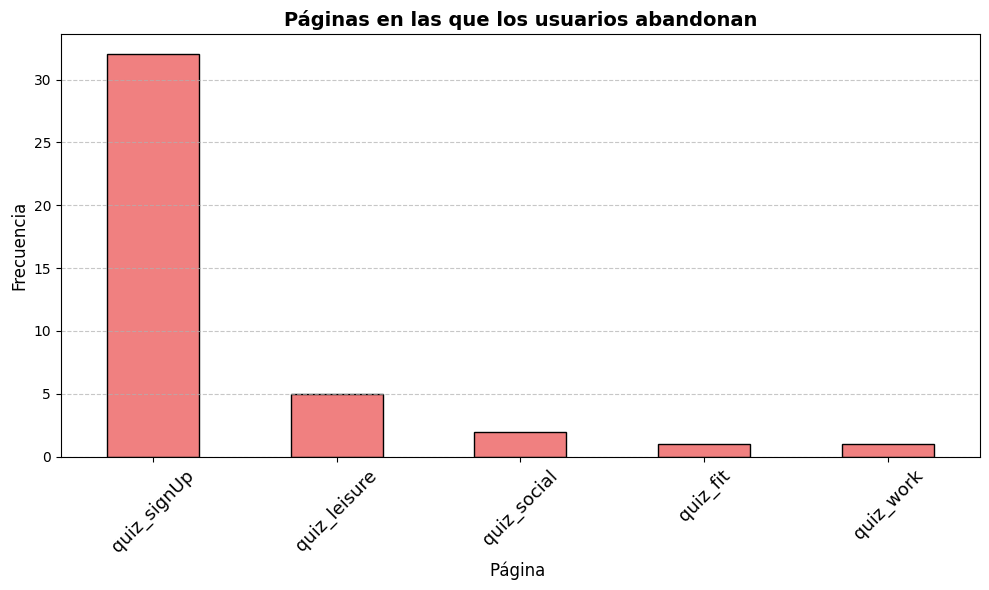

In [62]:
import matplotlib.pyplot as plt

# Obtener los datos
counts = df['last'].value_counts()

# Graficar
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Páginas en las que los usuarios abandonan', fontsize=14, weight = 'bold')
plt.xlabel('Página ', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [63]:
movement_df[movement_df['last'] == 'quiz_social']

,user_id,sections,movements,time_spent,length,first,last
16,7c4e48f6b2b5467082ecbec04e1f10c5,"[quiz_leisure, quiz_work, quiz_fit, quiz_highl...","[Avanza, Avanza, Avanza, Avanza, Avanza, Avanz...","[00:00:06, 00:00:07, 00:00:00, 00:00:12, 00:00...",41,quiz_leisure,quiz_social
27,bfe389a3d0744080825867c731cf194d,"[quiz_leisure, quiz_work, quiz_fit, quiz_highl...","[Avanza, Avanza, Avanza, Avanza, Avanza, Avanz...","[00:00:10, 00:00:07, 00:00:15, 00:00:33, 00:00...",19,quiz_leisure,quiz_social


Paginas que mas tiempo ocupan

In [64]:
# Función para calcular los valores mayores y menores o iguales a 30 minutos
def contar_tiempos(lista):
    # Convertimos cada tiempo en segundos
    tiempos_en_segundos = [
        sum(int(x) * 60 ** i for i, x in enumerate(reversed(tiempo.split(":"))))
        for tiempo in lista
    ]
    media_hora_segundos = 15 * 60  # 30 minutos en segundos
    # Contamos los valores que cumplen las condiciones
    mayor_a_15 = sum(1 for t in tiempos_en_segundos if t > media_hora_segundos)
    menor_o_igual_a_15 = sum(1 for t in tiempos_en_segundos if t <= media_hora_segundos)
    return mayor_a_15, menor_o_igual_a_15

# Aplicar la función a cada lista de la columna
movement_df[['mayores_15', 'menores_15']] = movement_df['time_spent'].apply(lambda x: pd.Series(contar_tiempos(x)))
movement_df.head()

,user_id,sections,movements,time_spent,length,first,last,mayores_15,menores_15
0,040e1e30c9ed4248bc9799a707e36d60,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...","[Avanza, Avanza, Avanza, Avanza, Avanza, Avanz...","[00:00:09, 00:00:13, 00:00:14, 00:01:06, 00:00...",18,quiz_work,quiz_signUp,0,18
1,08524cc6b3544d65af7faa39e9abd3f2,"[quiz_leisure, quiz_work, quiz_fit, quiz_highl...","[Avanza, Avanza, Avanza, Avanza, Avanza, Avanz...","[00:00:15, 00:00:07, 00:00:18, 00:00:19, 00:00...",57,quiz_leisure,quiz_signUp,1,56
2,0b9ab36679d64edbb7d6a830d103b91f,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...","[Avanza, Avanza, Avanza, Avanza, Avanza, Avanz...","[00:00:11, 00:00:11, 00:00:31, 00:00:27, 00:00...",18,quiz_work,quiz_signUp,0,18
3,0c4e7af8218440eaa383bc6655712a55,[quiz_leisure],[],[00:00:15],1,quiz_leisure,quiz_leisure,0,1
4,117c6171044e4fdf8cbd8c4dc6a59cb8,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...","[Avanza, Avanza, Avanza, Avanza, Avanza, Avanz...","[00:00:14, 00:00:09, 00:00:14, 00:00:41, 00:00...",18,quiz_work,quiz_signUp,0,18


In [65]:
import pandas as pd

# se filtra para obtener los users que no tienen tiempos mayores a 15 minutos y mas de una pagina vista
menores_15 = movement_df[movement_df['mayores_15'] < 1]
menores_15 = menores_15[menores_15['sections'].apply(lambda x: len(x) > 1)]

# Expandir las listas de 'sections' y 'time_spent' en filas individuales
expanded_df = menores_15.explode(['sections', 'time_spent'])

# Convertir la columna 'time_spent' a segundos
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds

expanded_df['time_spent_seconds'] = expanded_df['time_spent'].apply(time_to_seconds)

# Calcular la media del tiempo (en segundos) por página
average_time_per_page = (
    expanded_df.groupby('sections')['time_spent_seconds']
    .mean()
    .reset_index()
    .sort_values(by='time_spent_seconds', ascending=False)
)

# Opcional: Convertir de segundos a formato HH:MM:SS
def seconds_to_time(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

average_time_per_page['average_time'] = average_time_per_page['time_spent_seconds'].apply(seconds_to_time)

# Mostrar la tabla final
average_time_per_page[['sections', 'average_time', 'time_spent_seconds']]

,sections,average_time,time_spent_seconds
11,quiz_photos,00:03:50,230.208333
16,quiz_styles,00:01:04,64.000000
2,quiz_bodyShape,00:00:39,39.538462
14,quiz_sizes,00:00:38,38.041667
6,quiz_footwear,00:00:36,36.937500
0,quiz_adventurous,00:00:34,34.555556
13,quiz_signUp,00:00:30,30.840000
18,quiz_you,00:00:24,24.708333
1,quiz_avoid,00:00:22,22.360000
8,quiz_highlight,00:00:21,21.730769


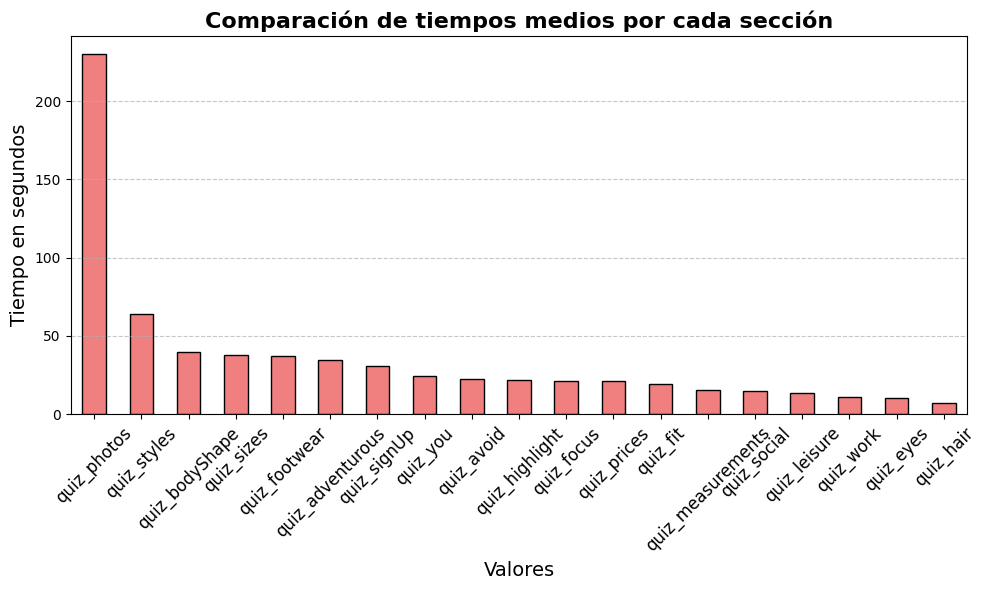

In [66]:
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama average_time_per_page
df_grouped = average_time_per_page.groupby('sections')['time_spent_seconds'].sum()

# Ordenar los valores de mayor a menor
df_grouped = df_grouped.sort_values(ascending=False)

# Crear el gráfico
plt.figure(figsize=(10, 6))
df_grouped.plot(kind='bar', color='lightcoral', edgecolor='black')

# Personalizar el gráfico
plt.title('Comparación de tiempos medios por cada sección', fontsize=16, weight = 'bold')
plt.xlabel('Valores', fontsize=14)
plt.ylabel('Tiempo en segundos', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar
plt.tight_layout()
plt.show()


In [67]:
# Imprimir cada sección con su tiempo correspondiente
def print_sections_time(id):
    sections = movement_df['sections'][id]
    time_spent = movement_df['time_spent'][id]
    print(movement_df['user_id'][id])
    for section, time in zip(sections, time_spent):
        print(f"{section}: {time}")

print_sections_time(5)

1285e4e59c0d43e4ac921cd9db535f0d
quiz_work: 00:00:22
quiz_fit: 00:00:41
quiz_highlight: 00:00:25
quiz_bodyShape: 00:00:31
quiz_eyes: 00:00:06
quiz_hair: 00:00:01
quiz_sizes: 00:00:29
quiz_measurements: 00:00:12
quiz_focus: 00:00:17
quiz_adventurous: 00:01:29
quiz_styles: 00:03:15
quiz_prices: 00:00:16
quiz_avoid: 00:00:10
quiz_footwear: 00:00:37
quiz_you: 00:00:52
quiz_photos: 00:20:08
quiz_social: 00:00:14
quiz_signUp: 00:00:15


Ruta mas frecuente

In [68]:
# Contar los recorridos únicos
path_counts = movement_df['sections'].value_counts().reset_index()
path_counts.columns = ['path', 'count']

# Calcular los porcentajes de cada recorrido
path_counts['percentage'] = (path_counts['count'] / path_counts['count'].sum()) * 100
path_counts['longitud'] = path_counts['path'].apply(lambda x: len(x))
 
# Mostrar los resultados
path_counts

,path,count,percentage,longitud
0,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...",11,26.829268,18
1,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...",5,12.195122,17
2,"[quiz_leisure, quiz_leisure]",2,4.878049,2
3,[quiz_leisure],2,4.878049,1
4,"[quiz_leisure, quiz_work, quiz_fit, quiz_highl...",2,4.878049,19
5,"[quiz_leisure, quiz_work, quiz_fit, quiz_highl...",1,2.439024,21
6,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...",1,2.439024,41
7,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...",1,2.439024,19
8,"[quiz_signUp, quiz_work, quiz_fit, quiz_highli...",1,2.439024,19
9,"[quiz_work, quiz_fit, quiz_highlight, quiz_bod...",1,2.439024,19


Nº avances, recargas, retrocesos

In [69]:
# Opcional: Analizar los movimientos ("Avanza", "Recarga", "Retrocede") a nivel agregado
movement_counts = movement_df['movements'].explode().value_counts().reset_index()
movement_counts.columns = ['movement', 'count']
movement_counts['percentage'] = (movement_counts['count'] / movement_counts['count'].sum()) * 100

print(movement_counts)

    movement  count  percentage
0     Avanza    683   90.703851
1  Retrocede     56    7.436919
2    Recarga     14    1.859230
